In [2]:
!pip install opencv-python torch torchvision mediapipe 

In [3]:
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


2025-04-22 02:46:37.332921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745289997.365451      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745289997.373315      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
test_data = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg"
frame = cv2.imread(test_data)

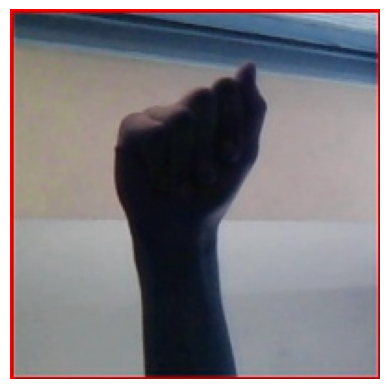

In [5]:
plt.imshow(frame)
plt.axis("off")
plt.show()

In [24]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

In [25]:
labels_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

In [26]:
def draw_landmarks(img_path):
    frame = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Initialize Hands with static image mode
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        # Process the image and get the result
        results = hands.process(image_rgb)
    
        # Check if hands are detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw landmarks on original image
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                    )
    return frame

In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Turn off TensorFlow logs (if used)
os.environ['GLOG_minloglevel'] = '3'  

In [19]:
import os

In [20]:
vocab = [x for x in [""] + os.listdir(labels_path)]

In [21]:
vocab

['',
 'N',
 'R',
 'space',
 'B',
 'I',
 'del',
 'F',
 'H',
 'E',
 'U',
 'M',
 'X',
 'K',
 'Q',
 'Y',
 'S',
 'G',
 'A',
 'O',
 'T',
 'V',
 'Z',
 'C',
 'P',
 'L',
 'W',
 'D',
 'nothing',
 'J']

In [27]:
num_to_char = {key:value for key, value in enumerate(vocab)}
char_to_num = {value:key for key, value in enumerate(vocab)}

In [28]:
def load_label(path):
    label = path.split("/")[-2]
    return char_to_num[label]

In [29]:
def load_data(path):
    frame,label = draw_landmarks(path),load_label(path)
    return frame,label

In [30]:
images_paths = [os.path.join(labels_path,key,value) for key in os.listdir(labels_path) for value in os.listdir(os.path.join(labels_path,key))] 

In [31]:
len(images_paths)

87000

In [57]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

class ImageDataset(Dataset):
    def __init__(self,paths,model = load_data):
        self.paths = paths
        self.model = model
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,idx):
        path = self.paths[idx]
        self.frame,self.label = self.model(path)
        # print(f"Load data {idx} of {len(self.paths)}")
        return torch.tensor(self.frame, dtype=torch.float32).permute(2,0,1),torch.tensor([self.label], dtype=torch.int64)
        

In [33]:
dataset = ImageDataset(images_paths)

In [34]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    Pads the sequences in a batch to the same length.

    Args:
        batch: A list of (data, label) tuples.

    Returns:
        A tuple containing the padded data and labels.
    """
    # Separate data and labels
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad the data (video frames)
    # Assuming data is a list of tensors of shape (num_frames, channels, height, width)
    # We need to pad along the num_frames dimension (dim=0)
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)

    # Pad the labels (alignments)
    # Assuming labels is a list of 1D tensors
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=0) # Assuming -1 is not a valid label


    return padded_data, padded_labels

In [35]:
train_size = round(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])


In [36]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [38]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
logging.getLogger().setLevel(logging.ERROR)
train_data, train_label = next(iter(train_loader))

In [41]:
train_data.size()

torch.Size([64, 3, 200, 200])

In [42]:
train_label.size()

torch.Size([64, 1])

In [43]:
num_to_char[train_label[1].tolist()[0]]

'del'

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASLClassifier(nn.Module):
    def __init__(self, num_classes=30):
        super(ASLClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input: [3, 200, 200]
        self.pool = nn.MaxPool2d(2, 2)  # Halves H and W
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # After 3 poolings: 200 → 100 → 50 → 25
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [16, 100, 100]
        x = self.pool(F.relu(self.conv2(x)))  # [32, 50, 50]
        x = self.pool(F.relu(self.conv3(x)))  # [64, 25, 25]
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here; use CrossEntropyLoss

        return x


In [45]:
model = ASLClassifier(num_classes=30)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
print(model)

ASLClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=40000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
)


In [ ]:
for epoch in range(1):  # Adjust as needed
    model.train()
    total_loss = 0
    print(f"\n=== Epoch {epoch+1} ===")

    for batch_idx, (images, labels) in enumerate(train_loader):
        labels = labels.squeeze()  # If shape is [B, 1], make it [B]

        print(f"\nBatch {batch_idx + 1}")

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        print(f"Batch loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Total Loss: {total_loss:.4f}")


In [48]:
model

ASLClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=40000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
)

In [79]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "checkpoint.pth")


In [50]:
test_data = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"
images = os.listdir(test_data)

In [53]:
labels = [i.split("_")[0] for i in images]
labels

['A',
 'E',
 'L',
 'N',
 'S',
 'D',
 'G',
 'I',
 'W',
 'M',
 'nothing',
 'X',
 'H',
 'Q',
 'C',
 'T',
 'P',
 'V',
 'Y',
 'U',
 'space',
 'O',
 'B',
 'R',
 'F',
 'Z',
 'J',
 'K']

In [54]:
test_images = [os.path.join(test_data,image) for image in images]

In [55]:
test_images

['/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/I_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/W_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/X_test.jpg',
 '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabe

In [63]:
test_frame = draw_landmarks(test_images[0])
                            

W0000 00:00:1745294197.010231  471298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294197.035738  471296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [64]:
test_frame.shape

(200, 200, 3)

In [69]:
test_1 = torch.tensor(draw_landmarks(test_images[0]), dtype=torch.float32).permute(2,0,1).unsqueeze(0)

W0000 00:00:1745294300.027797  476533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294300.038780  476533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [70]:
test_1.shape

torch.Size([1, 3, 200, 200])

In [71]:
result = model(test_1)

In [72]:
result

tensor([[-21.8501,   0.8133,  -4.3833,  -5.3471,   7.0534,  -0.2443, -10.7697,
           5.8462, -11.4573,   6.9711,  -2.2195,   3.9978,   3.1443,  -0.9749,
          -8.7751,   4.4866,   5.0297,  -4.1292,  11.5325,   0.1081,   3.0115,
          -0.4422,  -2.8661,  -1.3423, -11.3072,  -3.6218,   2.9549,   1.7461,
         -13.9824,  -3.3616]], grad_fn=<AddmmBackward0>)

In [77]:
decoded = torch.argmax(result, dim=1)

In [78]:
decoded

tensor([18])

In [81]:
def pred_results(path):
    frame = draw_landmarks(path)
    frame = torch.tensor(frame, dtype=torch.float32).permute(2,0,1).unsqueeze(0)
    result = model(frame)
    decoded = torch.argmax(result,dim = 1)
    return num_to_char[decoded.tolist()[0]]
    

In [82]:
results = [pred_results(path) for path in test_images]

W0000 00:00:1745294632.736713  493584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294632.755837  493584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294632.825357  493589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294632.835814  493589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294632.914566  493592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745294632.928596  493593 inference_feedback_manager.cc:114] Feedback manager 

In [87]:
results == labels

False

In [88]:
correct = sum(p == t for p, t in zip(results, labels))
accuracy = correct / len(labels)

print(f"Accuracy: {accuracy:.4f}")  # Output: 0.75

Accuracy: 0.8571
